In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import numpy as np
import shap

X_train,X_test,y_train,y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
shap.initjs()

In [ ]:
model = CatBoostClassifier()
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test)))
print(model.predict_proba(X_test))


# shap values with kernel explainer
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type="bar");

In [ ]:
# shap values with tree explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type="bar");

In [ ]:
# see https://catboost.ai/en/docs/concepts/shap-values
shap_values = model.get_feature_importance(data=Pool(X_test, y_test), type="ShapValues")
# shape (observations, features + 1 * expected_value)shap_values = model.get_feature_importance(data=Pool(X_test, y_test), type="ShapValues")
shap.summary_plot(shap_values[:,0,:-1], X_test, plot_type="bar");

In [ ]:
# similar to random feature permutation
# https://catboost.ai/en/docs/concepts/fstr#regular-feature-importance
model.get_feature_importance(data=Pool(X_test, y_test), type="FeatureImportance", prettified=True)

In [ ]:
# random feature permutation sklearn
r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)
# results are average; obviously not normalized to one.
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

## Attention Maps for Transformers

We calculate the average attention map from all transformer blocks, as done in the Gorishniy paper (see [here](https://github.com/Yura52/tabular-dl-revisiting-models/issues/2)). This is different from the Borisov paper (see [here](https://github.com/kathrinse/TabSurvey/blob/main/models/basemodel_torch.py)).

In [74]:
import sys

import pandas as pd
import seaborn as sns
import scipy.stats
import torch
from torch import nn

sys.path.append("..")
from otc.models.tabtransformer import TabTransformer

In [75]:
num_features_cont = 5
num_features_cat = 3
num_unique_cat = tuple([2,2, 2])
batch_size = 64


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_cat = torch.randint(0, 1, (batch_size, num_features_cat)).to(
            device
        )
x_cont = (
            torch.randn(batch_size, num_features_cont).float().to(device)
        )
expected_outputs = (
            torch.randint(0, 1, (batch_size, 1)).float().to(device)
        )

model = TabTransformer(
            cat_cardinalities=num_unique_cat,
            num_continuous=num_features_cont,
            dim_out=1,
            mlp_act=nn.ReLU,
            dim=32,
            depth=2,
            heads=6,
            attn_dropout=0.1,
            ff_dropout=0.1,
            mlp_hidden_mults=(4, 2)).to(device)

In [76]:
class SaveAttentionMaps:
    """
    Hook for attention maps.
    
    Inspired by:
    https://github.com/Yura52/tabular-dl-revisiting-models/issues/2#issuecomment-1068123629
    """
    def __init__(self):
        self.attention_maps: List[torch.Tensor] = []

    def __call__(self, _, __, output):
        print(output[1]["attention_probs"].shape)
        self.attention_maps.append(output[1]['attention_probs'])

In [77]:
# The following hook will save all attention maps from all attention modules.
hook = SaveAttentionMaps()
for block in model.transformer.blocks:
    block.attention.fn.fn.register_forward_hook(hook)

# Apply the model to all objects.
model.eval()
with torch.inference_mode():
    model(x_cat.clone(), x_cont.clone())

# Collect attention maps
n_objects = len(x_cat)
n_blocks = len(model.transformer.blocks)
n_heads = model.transformer.blocks[0].attention.fn.fn.n_heads

attention_maps = torch.cat(hook.attention_maps)

# Calculate feature importance and ranks.
attention_maps = attention_maps.reshape(n_objects * n_blocks * n_heads, num_features_cat, num_features_cat)
assert attention_maps.shape == (n_objects * n_blocks * n_heads, num_features_cat, num_features_cat)

# Calculate feature importance and ranks.
average_attention_map = attention_maps.mean(0)
feature_importance = average_attention_map[-1]

feature_importance = feature_importance.cpu().numpy()
feature_ranks = scipy.stats.rankdata(-feature_importance)
feature_indices_sorted_by_importance = feature_importance.argsort()[::-1]

print(feature_importance)
print(feature_ranks)
print(feature_indices_sorted_by_importance)

torch.Size([64, 6, 3, 3])
torch.Size([64, 6, 3, 3])
[0.35401863 0.31725085 0.32873052]
[1. 3. 2.]
[0 2 1]


[(0.0, 1.0)]

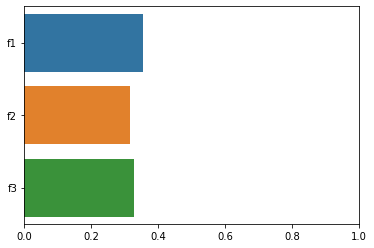

In [78]:
ax = sns.barplot(x = feature_importance, y = ["f1", "f2", "f3"])
ax.set(xlim=(0, 1))

In [79]:
from otc.models.activation import ReGLU
from otc.models.fttransformer import (
    CategoricalFeatureTokenizer,
    CLSToken,
    FeatureTokenizer,
    FTTransformer,
    MultiheadAttention,
    NumericalFeatureTokenizer,
    Transformer,
)

num_features_cont = 5
num_features_cat = 1
cat_cardinalities = [2]
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_cat = torch.randint(0, 1, (batch_size, num_features_cat)).to(
    device
)
x_cont = (
      torch.randn(batch_size, num_features_cont).float().to(device)
)
expected_outputs = (
        torch.randint(0, 1, (batch_size, 1)).float().to(device)
)

params_feature_tokenizer= {
        "num_continous": num_features_cont,
        "cat_cardinalities": cat_cardinalities,
        "d_token": 96,
}
feature_tokenizer = FeatureTokenizer(**params_feature_tokenizer)
params_transformer = {
            "d_token": 96,
            "n_blocks": 3,
            "attention_n_heads": 8,
            "attention_initialization": "kaiming",
            "ffn_activation": ReGLU,
            "attention_normalization": nn.LayerNorm,
            "ffn_normalization": nn.LayerNorm,
            "ffn_dropout": 0.1,
            "ffn_d_hidden": 96 * 2,
            "attention_dropout": 0.1,
            "residual_dropout": 0.1,
            "prenormalization": True,
            "first_prenormalization": False,
            "last_layer_query_idx": None,
            "n_tokens": None,
            "kv_compression_ratio": None,
            "kv_compression_sharing": None,
            "head_activation": nn.ReLU,
            "head_normalization": nn.LayerNorm,
            "d_out": 1,
        }

transformer = Transformer(**params_transformer)

model = FTTransformer(feature_tokenizer, transformer).to(device)

In [80]:
# Prepare data and model.
n_objects = len(x_cat)# 12
n_features = num_features_cont + num_features_cat

# The following hook will save all attention maps from all attention modules.
hook = SaveAttentionMaps()
for block in model.transformer.blocks:
    block.attention.register_forward_hook(hook)

# Apply the model to all objects.
model.eval()
with torch.inference_mode():
    model(x_cat, x_cont)

# Collect attention maps
n_blocks = len(model.transformer.blocks)
n_heads = model.transformer.blocks[0].attention.n_heads
n_tokens = n_features + 1
attention_maps = torch.cat(hook.attention_maps)
assert attention_maps.shape == (n_objects * n_blocks * n_heads, n_tokens, n_tokens)

# Calculate feature importance and ranks.
average_attention_map = attention_maps.mean(0)
average_cls_attention_map = average_attention_map[-1]  # consider only the [CLS] token
feature_importance = average_cls_attention_map[:-1]  # drop the [CLS] token importance
assert feature_importance.shape == (n_features,)

feature_importance = feature_importance.cpu().numpy()
feature_ranks = scipy.stats.rankdata(-feature_importance)
feature_indices_sorted_by_importance = feature_importance.argsort()[::-1]

print(feature_importance)
print(feature_ranks)
print(feature_indices_sorted_by_importance)

torch.Size([512, 7, 7])
torch.Size([512, 7, 7])
torch.Size([512, 7, 7])
[0.1375918  0.1466848  0.14887066 0.14371951 0.1427471  0.14100587]
[6. 2. 1. 3. 4. 5.]
[2 1 3 4 5 0]


[(0.0, 1.0)]

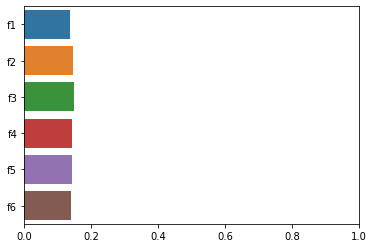

In [81]:
ax = sns.barplot(x = feature_importance, y = ["f1", "f2", "f3", "f4", "f5", "f6"])
ax.set(xlim=(0, 1))